# Бинарная классификация при помощи ML и DL

**Цель:** Классификация e-mail писем на фишинговые/безопасные.

**Использованные алгоритмы:** Logistic Regression (sklearn), LSTM (keras), DistilBERT (Hugging Face).

**Датасет:** Датасет состоит из 99706 записей — неочищенные тексты писем и классы (1 фишинговое/0 безопасное письмо).

**Источники данных:** 
1. https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset?select=phishing_email.csv
2. https://www.kaggle.com/datasets/subhajournal/phishingemails
3. https://zenodo.org/records/13474746

**Загрузка библиотек:**

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,
                             accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             roc_curve,
                             roc_auc_score,
                             precision_recall_curve,
                             average_precision_score)
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vist9/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\vist9/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\vist9/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Загрузка датасета:**

In [26]:
df = pd.read_csv('phishing_email_full.csv')
df.sample(10)

,text,label
7357,"benchmark fyi . . . according to jeff , by the...",0
5581,coated ceramic mugs if you don ' t wish to rec...,1
56299,nicolas bentley bedeckednt9yourcpaorg productl...,1
41545,technica indicators positive company oi gas ad...,1
38427,rac feeds 29 sep fyi forwarded debbie r bracke...,0
13527,"URL: http://www.newsisfree.com/click/-2,844395...",0
65144,kellie blanco jeannieussrmelvinspecialistinfoc...,1
21756,exclusive positions montanayoocwo sjk xl 20551...,1
57970,jami haynes iisbracicomorefr b se uy best ti e...,1
86387,sandy iwantsandycom tckhteqctonymeyeriwantsand...,0


# Предобработка данных

**Очистка текста:**

In [27]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
contractions = {"can't": 'cannot',
                "won't": 'will not',
                "i'm": 'i am',
                "it's": 'it is',
                "don't": 'do not',
                "didn't": 'did not',
                "doesn't": 'does not',
                "you're": 'you are',
                "they're": 'they are',
                "we're": 'we are',
                "i've": 'i have',
                "isn't": 'is not',
                "aren't": 'are not',
                "wasn't": 'was not',
                "weren't": 'were not',
                "hasn't": 'has not',
                "haven't": 'have not',
                "hadn't": 'had not',
                "wouldn't": 'would not',
                "shouldn't": 'should not',
                "couldn't": 'could not',
                "mustn't": 'must not'}

In [ ]:
def expand_contractions(text):
    for word, expanded in contractions.items():
        text = re.sub(r'\b' + word + r'\b', expanded, text)
    return text

def clean_text(text):
    '''
    Функция очистки текстов писем:
    1. Приведение к нижнему регистру
    2. Приведение сокращений к полной форме
    3. Удаление HTML-тегов
    4. Удаление URL-адресов
    5. Удаление email-адресов
    6. Удаление чисел
    7. Удаление специальных символов
    8. Лемматизация
    9. Удаление повторов, идущих друг за другом
    '''

    text = text.lower()
    text = expand_contractions(text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)

    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

    cleaned_tokens = []
    for w in tokens:
        if not cleaned_tokens or w != cleaned_tokens[-1]:
            cleaned_tokens.append(w)

    return ' '.join(cleaned_tokens)


df['clean_text'] = df['text'].apply(clean_text)

**Удаление дупликатов:**

In [29]:
df = df.drop_duplicates(subset=['text'])
df = df.drop_duplicates(subset=['clean_text'])

df.sample(10)

,text,label,clean_text
60851,per jessen ueecomputerorg aaron kulkis wrote o...,0,per jessen ueecomputerorg aaron kulkis wrote o...
21583,check hello want roooock harrrrd john son chec...,1,check hello want roooock harrrrd john son chec...
54287,charles marcus qqugswomediabrokerscom wed feb ...,0,charles marcus qqugswomediabrokerscom wed feb ...
17097,japanese specialist needed the linguistics res...,0,japanese specialist needed linguistics researc...
99064,mark rowsell jayemmegabw thisemailsfromatruste...,1,mark rowsell jayemmegabw thisemailsfromatruste...
98928,update account update_a0011outlookcom fyi used...,1,update account update outlookcom fyi used one ...
65924,jdd xyidodinorg carlos e r écrit question xp a...,0,jdd xyidodinorg carlos e r crit question xp ad...
10802,"On Thursday 19 September 2002 16:44, Michael M...",0,thursday september michael mckay wrote tue sep...
79296,burton larsen joaquinrepelshieldsworkerscompin...,1,burton larsen joaquinrepelshieldsworkerscompin...
40078,earn money home want make money home tired wor...,1,earn money home want make money home tired wor...


**Размер датасета после очистки:**

In [30]:
df.shape

(88689, 3)

**Разделение на текст и лейблы:**

In [31]:
texts = df['clean_text'].astype(str).values
labels = df['label'].values

# Logistic regression

In [32]:
word_vectorizer = TfidfVectorizer(analyzer='word')
char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))

combined_vectorizer = FeatureUnion([('word', word_vectorizer),
                                    ('char', char_vectorizer)])

X = combined_vectorizer.fit_transform(texts)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, labels,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
y_pred_prob_lr = model_lr.predict_proba(X_test)[:, 1]

print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Precision:', precision_score(y_test, y_pred_lr))
print('Recall:', recall_score(y_test, y_pred_lr))

Accuracy: 0.9854549554628481
Precision: 0.9835810960727757
Recall: 0.9877450980392157


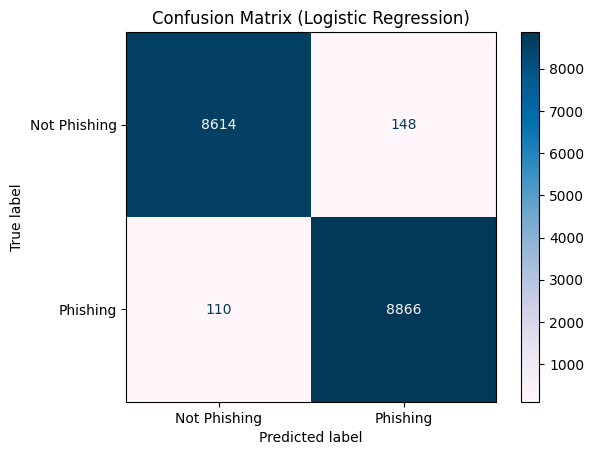

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Not Phishing', 'Phishing'])
disp.plot(cmap='PuBu')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

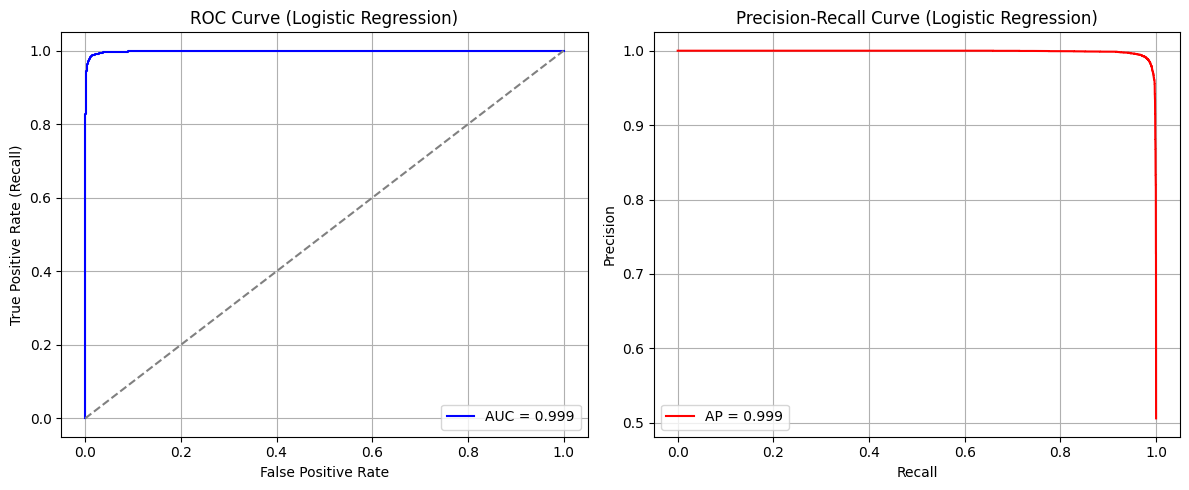

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lr)
auc = roc_auc_score(y_test, y_pred_prob_lr)

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob_lr)
avg_prec = average_precision_score(y_test, y_pred_prob_lr)

plt.figure(figsize=(12,5))

#ROC Curve
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve (Logistic Regression)')
plt.legend()
plt.grid(True)

#P-R Curve
plt.subplot(1,2,2)
plt.plot(recall, precision, label=f'AP = {avg_prec:.3f}', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Logistic Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# LSTM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels,
                                                    test_size=0.2,
                                                     random_state=42)

In [ ]:
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test),  maxlen=max_len)

In [ ]:
model_lstm = Sequential([Embedding(input_dim=20000, output_dim=128),
                         LSTM(64, return_sequences=False),
                         Dropout(0.5),
                         Dense(1, activation='sigmoid')])

model_lstm.compile(loss='binary_crossentropy', 
                   optimizer=Adam(1e-3), 
                   metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

history_lstm = model_lstm.fit(X_train, y_train, 
                              epochs=5, 
                              batch_size=128, 
                              validation_split=0.2)

Epoch 1/5
444/444 [==============================] - 144s 320ms/step - loss: 0.1243 - accuracy: 0.9551 - precision: 0.9519 - recall: 0.9597 - val_loss: 0.0584 - val_accuracy: 0.9810 - val_precision: 0.9818 - val_recall: 0.9806
Epoch 2/5
444/444 [==============================] - 148s 333ms/step - loss: 0.0353 - accuracy: 0.9889 - precision: 0.9876 - recall: 0.9906 - val_loss: 0.0576 - val_accuracy: 0.9804 - val_precision: 0.9841 - val_recall: 0.9770
Epoch 3/5
444/444 [==============================] - 150s 337ms/step - loss: 0.0196 - accuracy: 0.9942 - precision: 0.9939 - recall: 0.9946 - val_loss: 0.0699 - val_accuracy: 0.9832 - val_precision: 0.9773 - val_recall: 0.9898
Epoch 4/5
444/444 [==============================] - 152s 342ms/step - loss: 0.0129 - accuracy: 0.9963 - precision: 0.9956 - recall: 0.9971 - val_loss: 0.0768 - val_accuracy: 0.9828 - val_precision: 0.9843 - val_recall: 0.9816
Epoch 5/5
444/444 [==============================] - 151s 340ms/step - loss: 0.0090 - accura

In [ ]:
y_pred_prob_lstm = model_lstm.predict(X_test).ravel()
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)

print(classification_report(y_test, y_pred_lstm, 
                            target_names=['Not Phishing', 'Phishing']))

555/555 [==============================] - 16s 28ms/step
              precision    recall  f1-score   support

Not Phishing       0.98      0.99      0.99      8762
    Phishing       0.99      0.98      0.99      8976

    accuracy                           0.99     17738
   macro avg       0.99      0.99      0.99     17738
weighted avg       0.99      0.99      0.99     17738



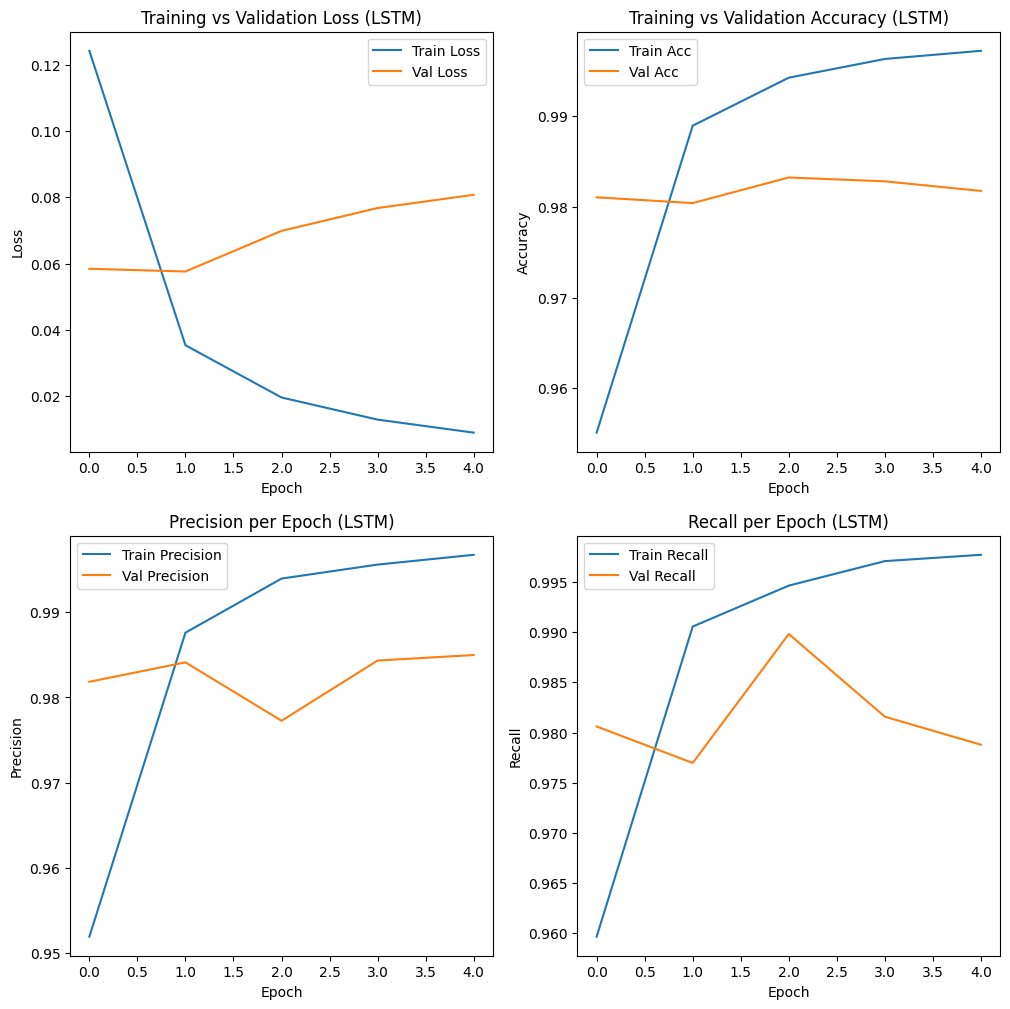

In [100]:
plt.figure(figsize=(12,12))

# Loss
plt.subplot(2,2,1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (LSTM)')
plt.legend()

# Accuracy
plt.subplot(2,2,2)
plt.plot(history_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (LSTM)')
plt.legend()


# Precision
plt.subplot(2,2,3)
plt.plot(history_lstm.history['precision'], label='Train Precision')
plt.plot(history_lstm.history['val_precision'], label='Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision per Epoch (LSTM)')
plt.legend()

# Recall
plt.subplot(2,2,4)
plt.plot(history_lstm.history['recall'], label='Train Recall')
plt.plot(history_lstm.history['val_recall'], label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall per Epoch (LSTM)')
plt.legend()

plt.show()

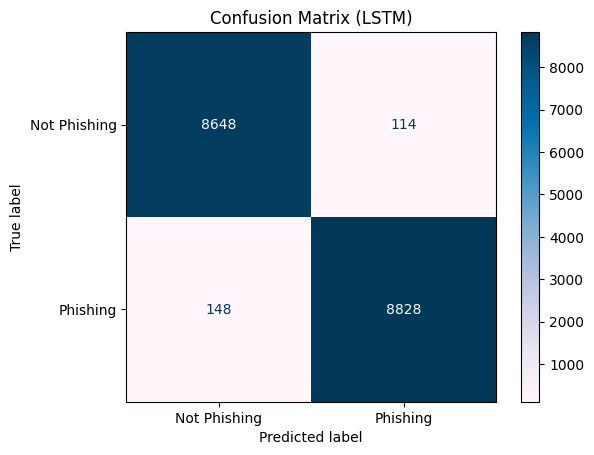

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Not Phishing', 'Phishing'])
disp.plot(cmap='PuBu')
plt.title('Confusion Matrix (LSTM)')
plt.show()

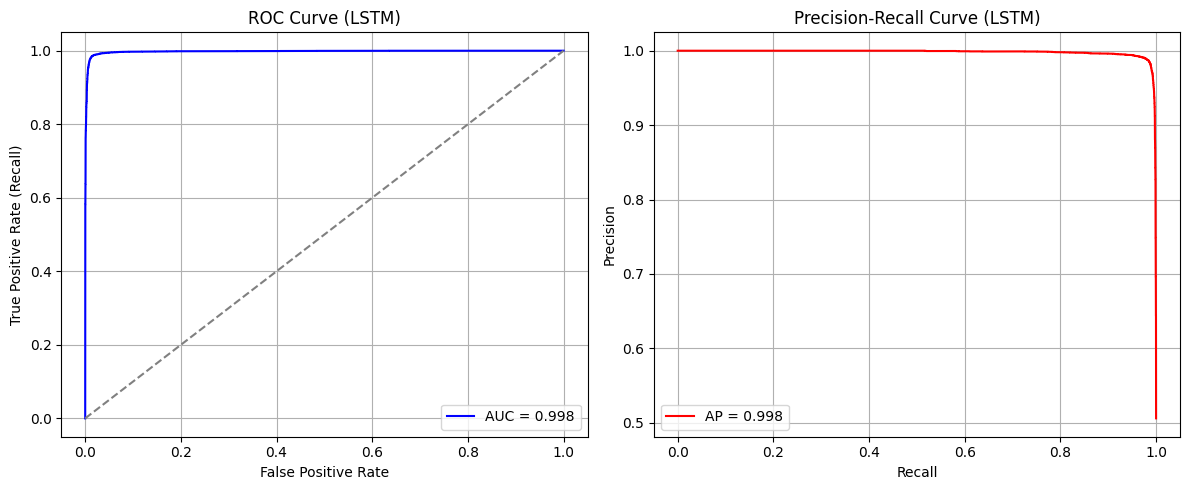

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lstm)
auc = roc_auc_score(y_test, y_pred_prob_lstm)

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob_lstm)
avg_prec = average_precision_score(y_test, y_pred_prob_lstm)

plt.figure(figsize=(12,5))

#ROC Curve
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve (LSTM)')
plt.legend()
plt.grid(True)

#P-R Curve
plt.subplot(1,2,2)
plt.plot(recall, precision, label=f'AP = {avg_prec:.3f}', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (LSTM)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# DistilBERT

In [75]:
texts_clean = [str(t) for t in texts if pd.notnull(t)]
labels_clean = [l for t, l in zip(texts, labels) if pd.notnull(t)]

X_train, X_test, y_train, y_test = train_test_split(
    texts_clean, labels_clean, test_size=0.2, random_state=42)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(X_train, 
                            truncation=True, 
                            padding='max_length', 
                            max_length=128, 
                            return_tensors='tf')

test_encodings = tokenizer(X_test, 
                           truncation=True, 
                           padding='max_length', 
                           max_length=128, 
                           return_tensors='tf')

In [77]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))\
    .shuffle(100).batch(16).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))\
    .batch(16).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_dbert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', 
                                                                    num_labels=2)

model_dbert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

history_dbert = model_dbert.fit(train_dataset, 
                                validation_data=test_dataset, 
                                epochs=2)

c:\Users\vist9\Работа\Python\Jupyter\ml_env\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification

Epoch 1/2
4435/4435 [==============================] - 19656s 4s/step - loss: 0.0631 - accuracy: 0.9776 - val_loss: 0.0435 - val_accuracy: 0.9855
Epoch 2/2
4435/4435 [==============================] - 19022s 4s/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.0268 - val_accuracy: 0.9915


In [ ]:
model_dbert.save_pretrained('./distilbert_model')
tokenizer.save_pretrained('./distilbert_model')

('./distilbert_model\\tokenizer_config.json',
 './distilbert_model\\special_tokens_map.json',
 './distilbert_model\\vocab.txt',
 './distilbert_model\\added_tokens.json')

In [ ]:
preds_dbert = model_dbert.predict(dict(test_encodings)).logits
y_pred_dbert = np.argmax(preds_dbert, axis=1)

logits = model_dbert.predict(dict(test_encodings)).logits  
all_probs = tf.nn.softmax(logits, axis=1).numpy()
probs_dbert = all_probs[:, 1]

print(classification_report(y_test, y_pred_dbert, 
                            target_names=['Not Phishing', 'Phishing']))

555/555 [==============================] - 1274s 2s/step
              precision    recall  f1-score   support

Not Phishing       0.99      0.99      0.99      8762
    Phishing       0.99      0.99      0.99      8976

    accuracy                           0.99     17738
   macro avg       0.99      0.99      0.99     17738
weighted avg       0.99      0.99      0.99     17738



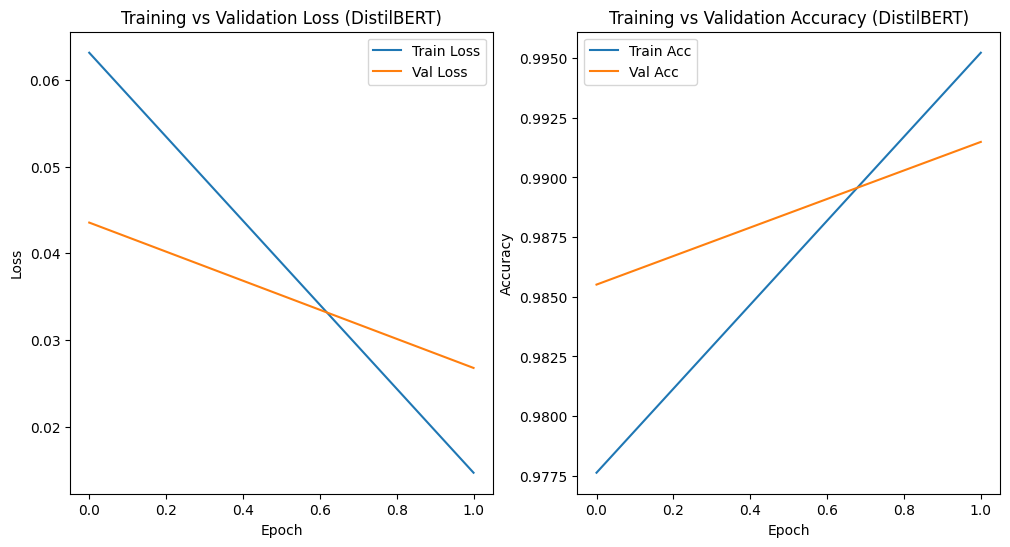

In [102]:
plt.figure(figsize=(12,6))

# Loss
plt.subplot(1,2,1)
plt.plot(history_dbert.history['loss'], label='Train Loss')
plt.plot(history_dbert.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (DistilBERT)')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_dbert.history['accuracy'], label='Train Acc')
plt.plot(history_dbert.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (DistilBERT)')
plt.legend()

plt.show()

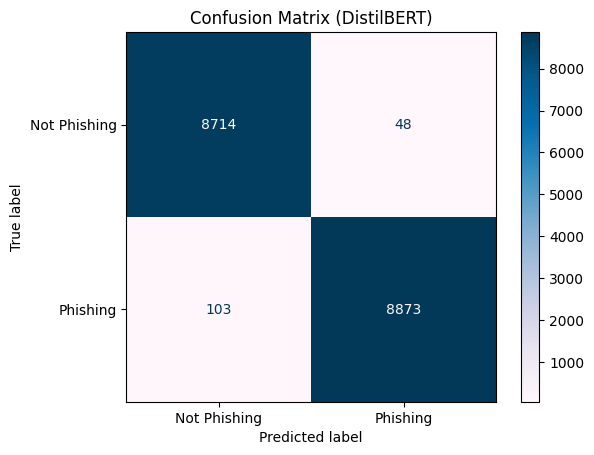

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dbert)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Not Phishing', 'Phishing'])
disp.plot(cmap='PuBu')
plt.title('Confusion Matrix (DistilBERT)')
plt.show()

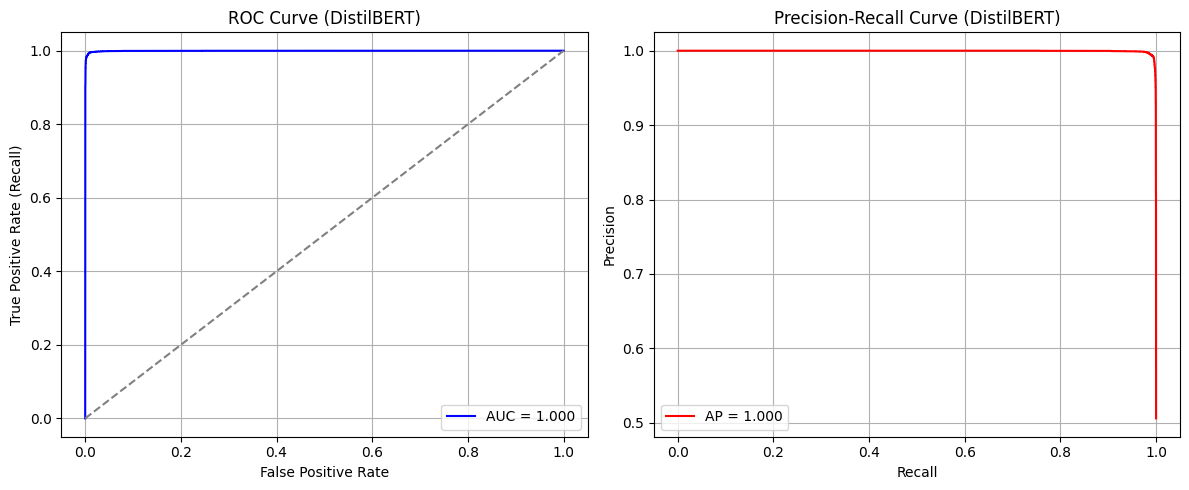

In [ ]:
fpr, tpr, _ = roc_curve(y_test, probs_dbert)
auc = roc_auc_score(y_test, probs_dbert)

precision, recall, thresholds_pr = precision_recall_curve(y_test, probs_dbert)
avg_prec = average_precision_score(y_test, probs_dbert)

plt.figure(figsize=(12,5))

#ROC Curve
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve (DistilBERT)')
plt.legend()
plt.grid(True)

#P-R Curve
plt.subplot(1,2,2)
plt.plot(recall, precision, label=f'AP = {avg_prec:.3f}', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (DistilBERT)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# Сравнение моделей

In [105]:
def get_metrics(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred)}

metrics_lr = get_metrics(y_test, y_pred_lr, 'Logistic Regression')
metrics_lstm = get_metrics(y_test, y_pred_lstm, 'LSTM')
metrics_bert = get_metrics(y_test, y_pred_dbert, 'DistilBERT')

df_metrics = pd.DataFrame([metrics_lr, metrics_lstm, metrics_bert])
df_metrics.set_index('Model', inplace=True)
display(df_metrics)

,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
Logistic Regression,0.985455,0.983581,0.987745,0.985659,0.985427
LSTM,0.985229,0.987251,0.983512,0.985378,0.985250
DistilBERT,0.991487,0.994619,0.988525,0.991563,0.991523


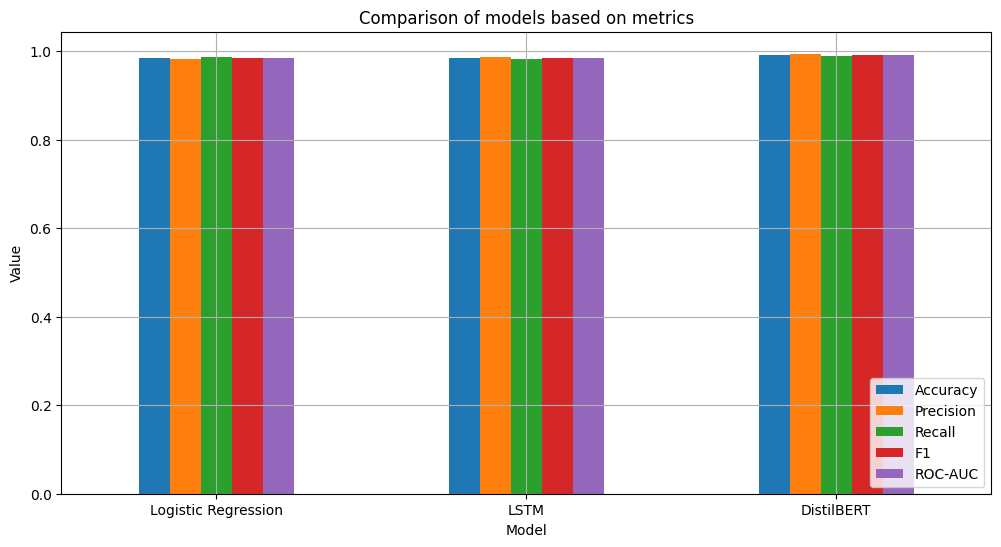

In [110]:
df_metrics.plot(kind='bar', figsize=(12,6))
plt.title('Comparison of models based on metrics')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()